# PET preprocessing+augmentation for the new and improved data pipeline 

Three steps involved:
1. Smoothing to remove/minimize PSF reconstruction artifacts, if any.
2. Intensity stretching at high SUV levels, as a data augmentation operation.
3. Intensity standardization and rescaling.

In [1]:
import os, time

import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import SimpleITK as sitk
import torchio

import sys
sys.path.append('../')
from data_utils.visualization import NdimageVisualizer

If you use TorchIO for your research, please cite the following paper:
Pérez-García et al., TorchIO: a Python library for efficient loading,
preprocessing, augmentation and patch-based sampling of medical images
in deep learning. Credits instructions: https://torchio.readthedocs.io/#credits



In [2]:
from notebook_utils import *

In [3]:
data_dir = "/home/chinmay/Datasets/HECKTOR/hecktor_train/crFH_rs113_hecktor_nii"
sample_patient_id = "CHGJ007"
pet_sitk = sitk.ReadImage(f"{data_dir}/{sample_patient_id}_pt.nii.gz") # Shape (W,H,D): 450x450x90 voxels

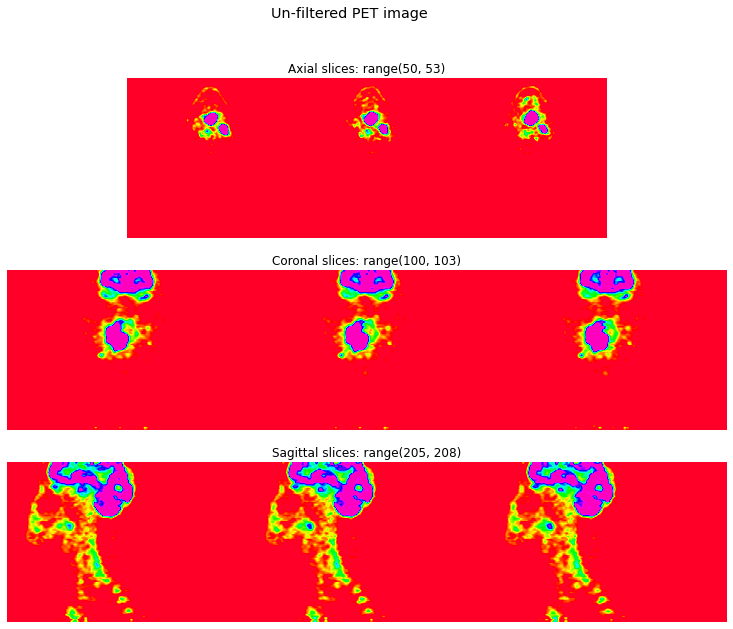

In [4]:
display_image(pet_sitk,
               axial_idxs=range(50,53),
               coronal_idxs=range(100,103),
               sagittal_idxs=range(205,208),
               window={'level':3, 'width':5},
               title="Un-filtered PET image", cmap='gist_rainbow')

## 1 Smoothing

In [5]:
pet_np = sitk.GetArrayFromImage(pet_sitk)

t1 = time.time()
sigma = [2.0/3, 2.0, 2.0] # In format (D,H,W), Physical sigma of 2mm adjusted according to voxel spacing
pet_smooth_np = scipy.ndimage.gaussian_filter(pet_np, sigma=sigma)
time_diff = time.time() - t1

print(f"Time taken for filtering: {time_diff:.2f}s")

Time taken for filtering: 0.76s


## 2 Data Augmentation

### 2.1 Intensity stretching

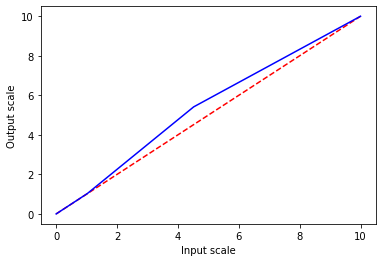

In [6]:
# Conceptual example on dummy data --

input_scale = np.arange(0, 10, 0.001)
output_scale = input_scale.copy()
max_val = 10

# Dummy percentile values
p30 = 1
p95 = 4.5

p95_increase_factor = 1.2

# Stretch the contrast in range [p30, p95)
mask = (input_scale>=p30) & (input_scale<p95)
output_scale[mask] = (input_scale[mask]-p30)/(p95-p30) * (p95_increase_factor*p95-p30) + p30

# Squeeze the contrast in range [p95, max]
mask = (input_scale>=p95) & (input_scale<=max_val)
output_scale[mask] = (input_scale[mask]-p95)/(max_val-p95) * (max_val-p95_increase_factor*p95) + p95_increase_factor*p95


plt.plot(input_scale, input_scale, 'r--')
plt.plot(input_scale, output_scale, 'b')
plt.xlabel("Input scale")
plt.ylabel("Output scale")
plt.show()

In [7]:
# Applying to PET -- stretch the contrast in the range between 30 percentile and 95 percentile 

pet_np = sitk.GetArrayFromImage(pet_sitk)
p30 = np.percentile(pet_np, 30)
p95 = np.percentile(pet_np, 95)
max_suv = pet_np.max()

print("30 percentile:", p30)
print("95 percentile:", p95)

p95_increase_factor = 1.2

pet_stretched_np = pet_smooth_np.copy()

# Stretch the contrast in range [p30, p95)
mask = (pet_smooth_np >= p30) & (pet_smooth_np < p95)
pet_stretched_np[mask] = (pet_smooth_np[mask]-p30)/(p95-p30) * (p95_increase_factor*p95-p30) + p30

# Squeeze the contrast in range [p95, max]
mask = (pet_smooth_np >= p95) & (pet_smooth_np <= 255)
pet_stretched_np[mask] = (pet_smooth_np[mask]-p95)/(max_suv-p95) * (max_suv-p95_increase_factor*p95) + p95_increase_factor*p95


30 percentile: 0.001372995984274894
95 percentile: 1.2746920585632324


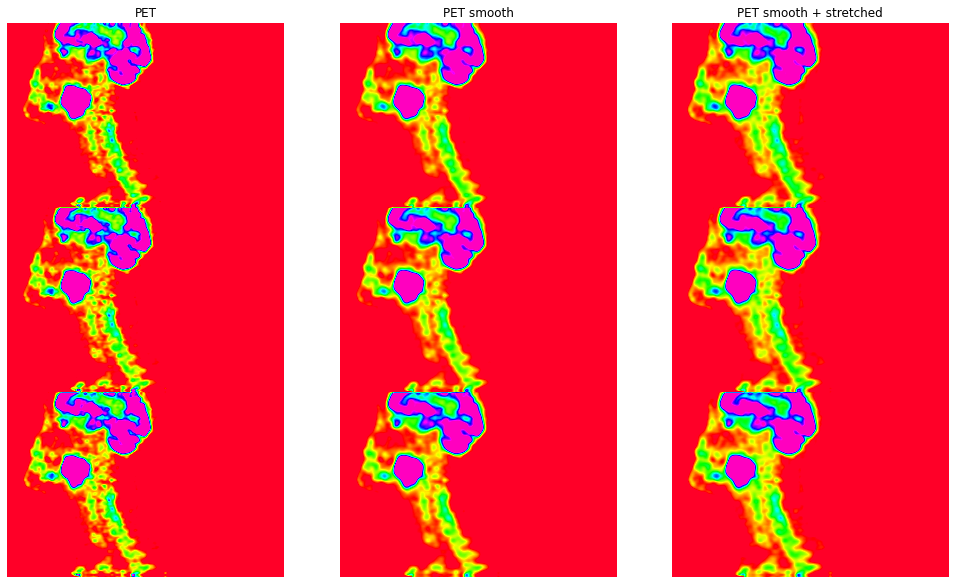

In [9]:
viz = NdimageVisualizer()
viz.multi_image_strips([pet_np, pet_smooth_np, pet_stretched_np.astype(np.float32)],
                          modalities=['PET'] * 3,
                          idx_range=[250, 253],
                          view='sagittal',
                          subtitles=["PET", "PET smooth", "PET smooth + stretched"])

### 2.2 Random rotation

### 2.3 Shear

### 2.4 Elastic distortion

## 3 Standardizing the Intensities